In [ ]:
from numpy import sqrt
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

### Generate ground-truth data

In [ ]:
time_steps = 100
sigma_meas = np.sqrt(0.125)
sigma_motion = np.sqrt(0.25)
motion_noise = np.random.normal(scale=sigma_motion,size=time_steps)
meas_noise = np.random.normal(scale=sigma_meas,size=time_steps)
fixed_velocity = 5
measured_v = fixed_velocity + motion_noise + meas_noise
actual_v = fixed_velocity + motion_noise
actual_position = np.cumsum(fixed_velocity + motion_noise/2)

### Kalman filter framework

Object moves along 1-D at near-constant velocity
- Position is of primary interest
- Velocity can be observed
- Define state $\psi_t = (x_t, v_t)$
- Noise is unknown acceleration

- Observation Model

$x_t = x_{t − 1} + v_{t − 1} +n_t/2$

$v_t = v_{t − 1} + n_t$

What is $F$ matrix? Remember 
$\psi_t = F\psi_{t-1} + n_t$

Process covariance is

$Q = \mathbf{E}[n_tn_t^T]$

In this case

$Q = \sigma_n^2\begin{bmatrix} 0.25 & 0.5 \\
0.5 & 1.0\end{bmatrix}$

- Measurement Model

$Z_t = v_t+m_t$

What is the $H$ matrix? Remember

$Z_t = H\psi_t + m_t$

Measurement covariance is

$R = \mathbf{E}[m_tm_t^T]$

In this case $R = \sigma^2_m$

##Kalman filter

#### Predict step
$\psi_t = F\psi_{t-1}$
$P_t = FP_{t-1}F^T + Q$

#### Correction step

Innovation term: $I_t = Z_t - H\psi_t$

$\psi_t := \psi_t + K I_t$

Kalman gain: $K = P_tH^T(HP_tH^T + R)^{-1}$

$P_t = (I-KH)P_t$


In [ ]:
class Kalman(object):
    def __init__(self):
        self.state = np.array([[0.0], [0.0]])
        self.F = np.array([[1,1],[0,1]]) #fill in the motion model
        self.H = np.array([[0,1]])#fill in the measurement model
        self.Q = (sigma_motion**2)*np.array([[0.25,0.5],[0.5,1]]) #fill in process covariance (assume sigma_n is known)
        self.R = sigma_meas**2 #fill in sensor covariance (assume sigma_m is known)
        self.P = 0.1*np.eye(2)
        
    def predict(self):
        self.state = self.F@self.state #update state with self.F
        self.P = self.F@self.P@(self.F).T + self.Q #update state covariance
    
    def correct(self, measurement):
        S = (self.H @ self.P @ self.H.T + self.R)
        kalman = (self.P @ (self.H).T) / S 
        innovation = measurement -self.H@self.state   #fill in innovation given measurement and 
        #current state, self.state
        self.state = self.state + innovation * kalman
        self.P = (np.eye(2) - kalman*self.H) @ self.P

### 1-D Robot simulation

In [ ]:
kf = Kalman()
filtered = []
for v in measured_v:
        #write the predict() of Kalman class
        kf.predict()
        #write the correct() (argument is v) of Kalman
        kf.correct(v)
        filtered.append([*kf.state]) #appending (x, v) to the filtered array
filtered = np.array(filtered)

In [ ]:
actual_position = np.reshape(actual_position,np.shape(filtered[:,0]))
rmse_pos = np.sqrt(np.mean((actual_position-filtered[:,0])**2))
actual_v = np.reshape(actual_v,np.shape(filtered[:,1]))
rmse_vel = np.sqrt(np.mean((actual_v-filtered[:,1])**2))
print(f"Average error position: {rmse_pos} velocity: {rmse_vel}")

Average error position: 2.3670148343018993 velocity: 0.337970991909977


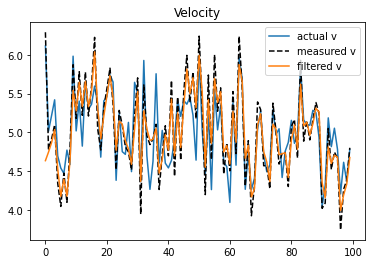

In [ ]:
plt.figure()
plt.title('Velocity')
plt.plot(actual_v, label='actual v')
plt.plot(measured_v, 'k--', label='measured v')
plt.plot(filtered[:,1], label='filtered v')
plt.legend()

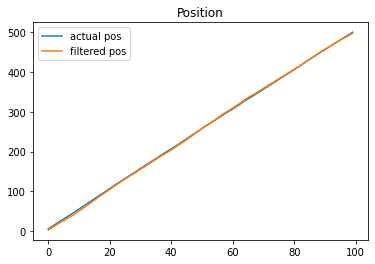

In [ ]:
plt.figure()
plt.title('Position')
plt.plot(actual_position, label='actual pos')
plt.plot(filtered[:,0], label='filtered pos')
plt.legend()